### **Uvod u znanost o podacima (UZOP) - Projekt - Drugi dio**
***

In [322]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random as rng
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Za uljepšavanje Seaborn vizualizacija, definirano je par boja koje će se onda nasumično birati za svaki graf.

In [323]:
def get_color():
    colors = sns.color_palette("muted")
    return rng.sample(colors, 1)[0]

#### 0. Učitavanje dataseta

In [324]:
dataset = pd.read_csv('CBWDB.csv')
dataset.head(8)

,SEC,Age(years),Height(cm),Bgroup,Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,BPL,23.0,146.0,A(+ve),1.0,4.0,34.0,42.0,116.0,78.0,120.0,70.0,10.0,13.2,90.0,T,F,2.7,2.0
1,BPL,25.0,165.0,NIL,1.0,3.0,68.0,71.0,96.0,70.0,110.0,72.0,10.4,11.0,96.0,T,M,2.9,2.0
2,BPL,24.0,155.0,B(+ve),1.0,3.0,49.0,55.0,91.0,52.0,110.0,70.0,11.0,11.6,102.0,T,M,2.4,1.0
3,BPL,19.0,154.0,NIL,1.0,2.0,49.0,50.0,90.0,52.0,100.0,60.0,10.0,10.6,103.0,T,F,2.6,2.0
4,BPL,21.0,150.0,NIL,1.0,4.0,41.0,48.0,100.0,60.0,110.0,70.0,9.0,10.2,99.0,T,F,2.3,1.0
5,BPL,19.0,150.0,O(+VE),0.0,4.0,44.0,54.0,100.0,70.0,120.0,80.0,9.0,9.8,93.0,T,F,2.5,2.0
6,BPL,15.0,147.0,NIL,0.0,4.0,37.0,45.0,80.0,50.0,90.0,70.0,8.9,10.0,97.0,T,M,2.5,2.0
7,BPL,24.0,153.0,O(+VE),1.0,3.0,50.0,59.0,100.0,60.0,110.0,60.0,9.5,11.0,111.0,PT,M,3.0,2.0


Kao i iz opisa dataseta, može se vidjeti da on sadrži 19 različitih značajki, od kojih je posljednja ciljna (3 kategorije težine djeteta), i sveukupno 1800 podatkovnih redaka.

**SEC** - Socio-Economic Condition  
**Age(years)** - Age of mother at the time of pregnancy  
**Height(cm)** - Height of mother at the time of pregnancy  
**Bgroup** - Blood Group of mother  
**Parity** - No. of previous pregnancy crossing the period of viability  
**ANC** - Antenatal Check  
**Iwt(kg)** - Initial weight of mother  
**FWt(kg)** - Final weight of mother (Last ANC)  
**IBP_sys** - Initial systolic Blood Pressure  
**IBP_dias** - Initial diastolic Blood Pressure  
**FBP_sys** - Final systolic Blood Pressure (Last ANC)  
**FBP_dias** - Final diastolic Blood Pressure (last ANC)  
**IHb(gm%)** - Initial Haemoglobin level  
**FHb(gm%)** - Final Haemoglobin level (Last ANC)  
**BS(RBS)** - Blood Sugar (Random)  
**Term/Preterm** - **Term**: 37 to 40 weeks, **Preterm**: <37 weeks  
**Sex** - Sex of new born baby  
**BWt(kg)** - Baby birth weight  
  
**LNH** - Low-weight (1), Normal-weight (2), Over-weight (3) 

#### 1. Vrijednosti target stupca
Odmah s početka, pogledat ćemo kako ugrubo izgleda distribucija ciljnog **LNH** atributa, odnosno i **BWt(kg)** pošto označavaju istu stvar.

Low-weight: 142,    Normal-weight: 926,    Over-weight: 4


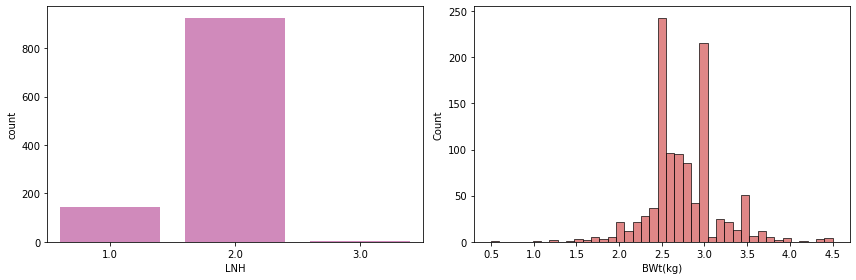

In [325]:
print(f"Low-weight: {(dataset['LNH'] == 1).sum()},\
    Normal-weight: {(dataset['LNH'] == 2).sum()},\
    Over-weight: {(dataset['LNH'] == 3).sum()}")

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes = axes.flatten()

sns.barplot(dataset["LNH"].value_counts(), ax=axes[0], color=get_color())
sns.histplot(dataset, x='BWt(kg)', ax=axes[1], color=get_color())

plt.tight_layout()
plt.show()

Vidimo da je jako veliki dio LNH vrijednosti upravo 2 što označava normalnu težinu. Takva distribucija, iako nije baš pogodna za klasifikaciju, reflektira stvarnu situaciju kod poroda djeteta, kada je u samo manjem broju slučaja novorođenče premale ili prevelike tjelesne težine.

#### 2. Provjera monotonih i konstantnih vrijednosti
Iz samog opisa atributa, moguće je zaključiti da ovaj skup podataka nema niti monotonih niti konstantnih vrijednosti, ali za svaki slučaj da se uvjerimo ćemo pokrenuti metode koje detektiraju takve stupce.

In [326]:
monotonic = []
constant = []

for col in dataset.columns:
    if dataset[col].is_monotonic_increasing or dataset[col].is_monotonic_decreasing:
        monotonic.append(col)
    elif dataset[col].nunique() == 1:
        constant.append(col)

print(f'Monotone značajke: {len(monotonic)}')
print(f'Konstantne značajke: {len(constant)}')

columns_to_remove = set(monotonic)
columns_to_remove.update(constant)
dataset = dataset.drop(columns=columns_to_remove)

Monotone značajke: 0
Konstantne značajke: 0


#### 3. Provjera nedostajućih vrijednosti
Provjeravat ćemo konkretan broj vrijednosti koje nedostaju u nekom stupcu, i zbog povećanja informacijske koristi i postotak tih nedostajućih vrijednosti u odnosi na ukupan broj vrijednosti.

In [327]:
def show_missing_values(dataset):
    missing_values = pd.DataFrame(dataset.isna().sum())
    missing_values["%"] = missing_values / len(dataset) * 100
    missing_values = missing_values.sort_values(by="%", ascending=False)
    print(missing_values)
show_missing_values(dataset)

                 0          %
BS(RBS)       1192  66.222222
Bgroup        1002  55.666667
Term/Preterm   838  46.555556
LNH            728  40.444444
BWt(kg)        728  40.444444
Sex            658  36.555556
SEC            650  36.111111
FHb(gm%)       407  22.611111
IHb(gm%)       405  22.500000
Height(cm)     273  15.166667
FWt(kg)         61   3.388889
FBP_dias        52   2.888889
FBP_sys         51   2.833333
Iwt(kg)         49   2.722222
IBP_sys         40   2.222222
IBP_dias        40   2.222222
Parity          33   1.833333
ANC             19   1.055556
Age(years)      14   0.777778


Ono što je najzabrinjavajuće je da više od 40% ciljnog **LNH** nema vrijednost. To predstavlja veliki problem jer takve retke je nemoguće upotrijebiti za klasifikaciju te će oni morati biti obrisani. Time smo reducirali ukupni dataset za 40% što je poprilično loše, ali način za povratiti takve nepostojeće ciljne podatke ne postoji.

In [328]:
dataset.dropna(subset=["LNH"], inplace=True)
show_missing_values(dataset)

                0          %
BS(RBS)       531  49.533582
Bgroup        367  34.235075
SEC           200  18.656716
Term/Preterm  133  12.406716
Height(cm)    128  11.940299
IHb(gm%)      103   9.608209
FHb(gm%)      102   9.514925
FWt(kg)        13   1.212687
Iwt(kg)        12   1.119403
Sex            11   1.026119
FBP_sys         6   0.559701
FBP_dias        6   0.559701
IBP_dias        4   0.373134
IBP_sys         4   0.373134
Age(years)      3   0.279851
ANC             0   0.000000
Parity          0   0.000000
BWt(kg)         0   0.000000
LNH             0   0.000000


Značajke **BS(RBS)** koja predstavlja razinu šećera u krvi majke fali gotovo 50%. U tome što učiniti s njome pomoći će nam prikaz distribucije.

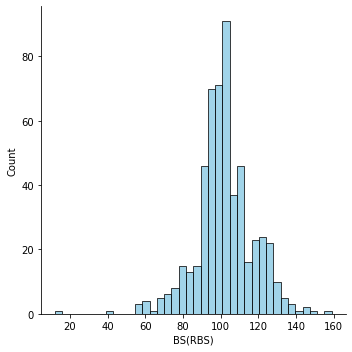

In [329]:
sns.displot(dataset["BS(RBS)"], color=get_color())

Vidimo da ta značajka prati Gaussovu distribuciju što znači da nedostajuće vrijednosti možemo zamijeniti srednjom vrijednošću.  
  
Značajka **Bgroup**, koja predstavlja krvnu grupu majke, također ima mnogo nedostajućih vrijednosti, ali [istraživanjem](https://www.ijrcog.org/index.php/ijrcog/article/view/2803) možemo doznati da u stvarnom svijetu krvna grupa majke gotovo pa nema nikakvog značajnog utjecaja na težinu djeteta. Stoga kako bi smanjili šum, ovaj će stupac biti obrisan.  
  
Kategorička značajka **SEC** nije direktan pokazatelj težine novorođenčadi (ne opisuje nikakve zdravstvene karakteristike majke). Pošto ne možemo zamijeniti sa srednjom vrijednosti, izgubili bismo 200 zapisa brisanjem zapisa, pa će stoga **SEC** isto biti kompletno obrisan kao značajka. 

**Term/Preterm** je jako bitna značajka za težinu novorođenčadi, pa brisanje stupca ne dolazi u obzir, kao niti zamjena sa srednjom vrijednosti pošto se radi o kategoričkom atributu. Ovdje će morati biti obrisani zapisi s null vrijednostima.

Kategorička značajka **Sex** ima samo 11 nedostajućih zapisa pa ćemo i njih obrisati.

Ostale numeričke značajke (**Height(cm)**, **IHb(gm%)**, **FHb(gm%)**, **FWt(kg)**, **Iwt(kg)**, **FBP_sys**, **FBP_dias**, **IBP_dias**, **IBP_sys**, **Age(years)**) ćemo dopuniti srednjom vrijednošću.

In [330]:
# brisanje stupca Bgroup
dataset.drop(["Bgroup"], axis=1, inplace=True)

# brisanje stupca SEC
dataset.drop(["SEC"], axis=1, inplace=True)

# brisanje zapisa s null vrijednostima stupca Term/Preterm
dataset.dropna(subset=["Term/Preterm"], inplace=True)

# brisanje zapisa s null vrijednostima stupca Sex
dataset.dropna(subset=["Sex"], inplace=True)

# zamjena null vrijednosti ostalih numeričkih značajki pripadajućom srednjom vrijednošću
columns = ["BS(RBS)", "Height(cm)", "IHb(gm%)", "FHb(gm%)", "FWt(kg)", "Iwt(kg)",
           "FBP_sys", "FBP_dias", "IBP_dias", "IBP_sys", "Age(years)"]
for col in columns:
    dataset.loc[dataset[col].isna(), col] = dataset.loc[:, col].mean()

show_missing_values(dataset)

              0    %
Age(years)    0  0.0
FBP_dias      0  0.0
BWt(kg)       0  0.0
Sex           0  0.0
Term/Preterm  0  0.0
BS(RBS)       0  0.0
FHb(gm%)      0  0.0
IHb(gm%)      0  0.0
FBP_sys       0  0.0
Height(cm)    0  0.0
IBP_dias      0  0.0
IBP_sys       0  0.0
FWt(kg)       0  0.0
Iwt(kg)       0  0.0
ANC           0  0.0
Parity        0  0.0
LNH           0  0.0


Sada kada smo "srezali" sve stupce i retke, možemo za lakoću u budućnosti staviti tekstualne kategoričke značajke u jednu listu, a numeričke u drugu za lakše manipuliranje podacima.

In [331]:
categorical_cols = ["Term/Preterm", "Sex", "LNH"]
numerical_cols = ["Age(years)", "Height(cm)", "Parity", "ANC", "Iwt(kg)", "FWt(kg)", "IBP_sys",
                  "IBP_dias", "FBP_sys", "FBP_dias", "IHb(gm%)", "FHb(gm%)", "BS(RBS)", "BWt(kg)"]

#### 4. Provjera stršećih vrijednosti

Pošto je velik broj značajki numerički, morat ćemo prikazati tekstualno statističke podatke i također vizualizirati ih za efektivno uočavanje stršećih vrijednosti.

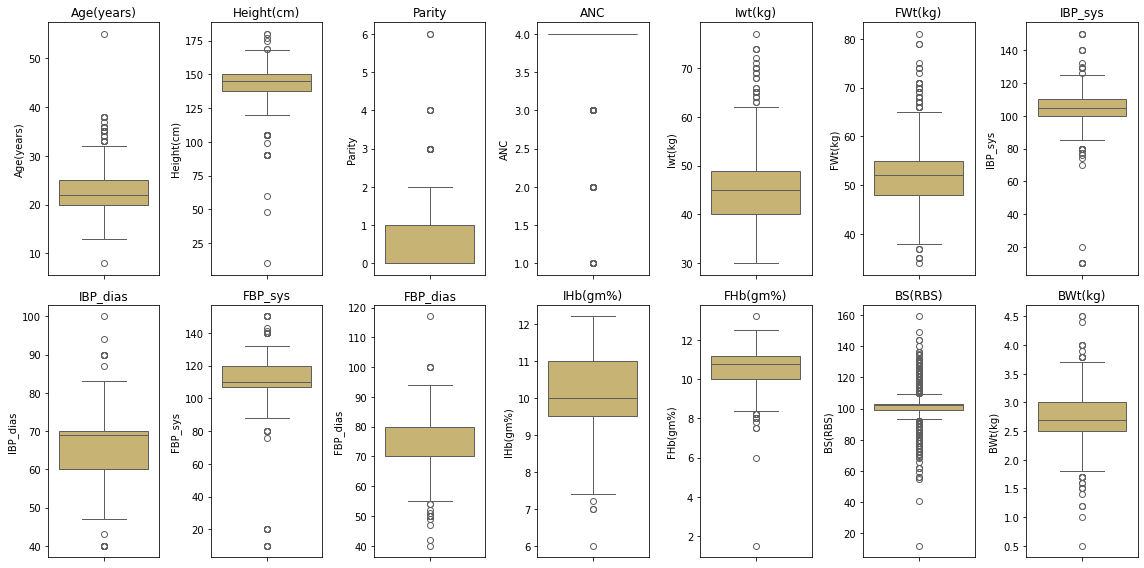

In [332]:
fig, axes = plt.subplots(2, 7, figsize=(16, 8))
axes = axes.flatten()

color = get_color()
for i, col in enumerate(numerical_cols):
    sns.boxplot(dataset[col], ax=axes[i], color=color)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [333]:
dataset[numerical_cols].describe()

,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),BWt(kg)
count,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,22.863784,141.176398,0.521552,3.752155,45.508734,52.411900,104.401515,66.437229,110.448537,71.622969,10.087211,10.644766,102.037175,2.761175
std,4.406384,14.980496,0.838379,0.634325,6.925628,6.738135,12.080458,7.887789,13.822277,8.348452,0.996669,0.950467,11.721289,0.421881
min,8.000000,10.000000,0.000000,1.000000,30.000000,34.000000,10.000000,40.000000,10.000000,40.000000,6.000000,1.500000,12.000000,0.500000
25%,20.000000,138.000000,0.000000,4.000000,40.000000,48.000000,100.000000,60.000000,107.000000,70.000000,9.500000,10.000000,99.000000,2.500000
50%,22.000000,145.000000,0.000000,4.000000,45.000000,52.000000,105.000000,69.000000,110.000000,70.000000,10.000000,10.800000,102.037175,2.700000
75%,25.000000,150.000000,1.000000,4.000000,49.000000,55.000000,110.000000,70.000000,120.000000,80.000000,11.000000,11.200000,103.000000,3.000000
max,55.000000,180.000000,6.000000,4.000000,77.000000,81.000000,150.000000,100.000000,150.000000,117.000000,12.200000,13.200000,159.000000,4.500000


Iz priloženoga se da zaključiti da numeričke značajke generalno nemaju nekih prevelikih odstupanja, osim u **Height(cm)** i **BS(RBS)**.  
  
Za **Height(cm)**, nemoguće je da je minimalna visina majke 10 centimetara, čak su i vrijednosti oko 50 centimetara poprilično nerealne (iako, iz minimalne vrijednosti **Age(years)** saznajemo potresnu informaciju da je neka majka imala 8 godina prilikom poroda) pa ćemo ih obrisati.

U **BS(RBS)** minimalna vrijednost je 12 što je ponovno nerealno (po nekim izvorima, osoba s razinom šećera u krvi ispod 54 kreće imati napadaje i pada u komu), ali ćemo ju za sad ipak ostaviti.

In [334]:
dataset = dataset[dataset['Height(cm)'] >= 50]

#### 5. Vizualizacija značajki

Tekstualne kategoričke značajke, zajedno s ciljnom značajkom **LNH**, ćemo vizualizirati na način da vidimo koliko unikatnih vrijednosti one sadrže.

              count      %
Term/Preterm              
T               858  92.66
PT               68   7.34

     count      %
Sex              
M      485  52.38
F      439  47.41
T        2   0.22

     count      %
LNH              
2.0    805  86.93
1.0    117  12.63
3.0      4   0.43



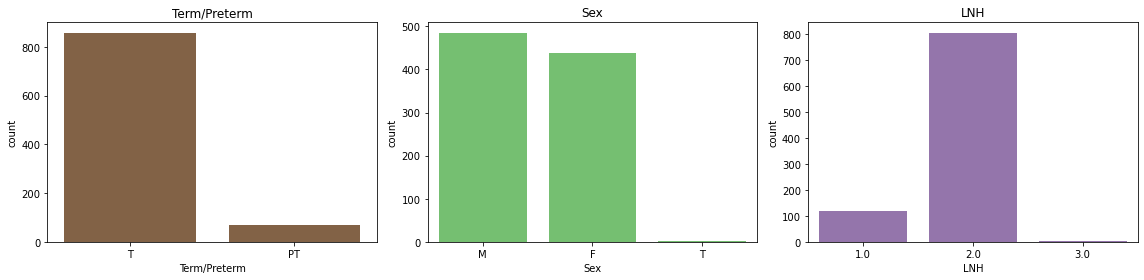

In [335]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    sns.barplot(dataset[col].value_counts(), ax=axes[i], color=get_color())
    axes[i].set_title(col)

    new_df = pd.DataFrame(dataset[col].value_counts())
    new_df["%"] = round(new_df / len(dataset) * 100, 2)

    print(f'{new_df}\n')

plt.tight_layout()
plt.show()

Vidimo da **Sex** stupac sadrži 2 vrijednosti "T" (vjerojatno *transsexual*?) što bi potencijalno moglo zbuniti model, ali za sad ćemo samo biti svjesni toga. Također, ciljni **LNH** ima za *Over-weight* samo 4 zapisa što je vrlo nebalansirano u usporedbi s *Low-weight* i *Normal-weight*.
  
Također, možemo prikazati kako se broj **Term/Preterm** vrijednosti mijenja po različitim vrijednostima klase **LNH**.


---Target: 2.0---
Term: 95.65%
Preterm: 4.35%

---Target: 1.0---
Term: 71.79%
Preterm: 28.21%

---Target: 3.0---
Term: 100.0%


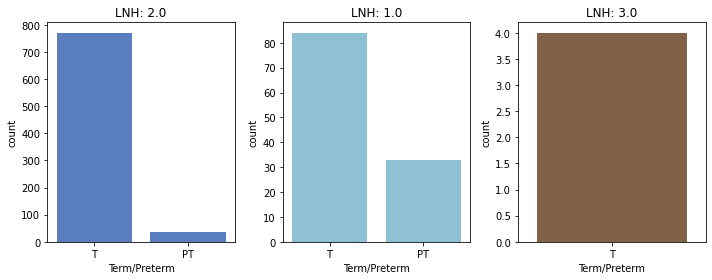

In [336]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4))
axes = axes.flatten()

for i, target in enumerate(dataset["LNH"].unique()):
    print(f"\n---Target: {target}---")
    selected = dataset[dataset["LNH"] == target]
    values = selected["Term/Preterm"].value_counts()
    sns.barplot(values, ax=axes[i], color=get_color())
    axes[i].set_title(f"LNH: {target}")
    print(f"Term: {round(values['T'] / len(selected) * 100, 2)}%")
    if (i != 2):
        print(f"Preterm: {round(values['PT'] / len(selected) * 100, 2)}%")

plt.tight_layout()
plt.show()

Vidljivo je iz grafova da je udio Preterm novorođene djece s nižom težinom veći od one novorođene djece s normalnom težinom. To ima smisla jer novorođenčad koja je "uranila" s rođenjem i imaju manju tjelesnu težinu od onih koji su rođeni "na vrijeme".

Sada ćemo vizualizirati neke numeričke značajke na način koji bi nam mogao ukazati na interesantne odnose između podataka.

Prvo, možemo vidjeti razdiobu inicijalne težine majke **Iwt(kg)** i konačne težine majke **Fwt(kg)** u odnosu na težinu novorođenog djeteta **LNH**.

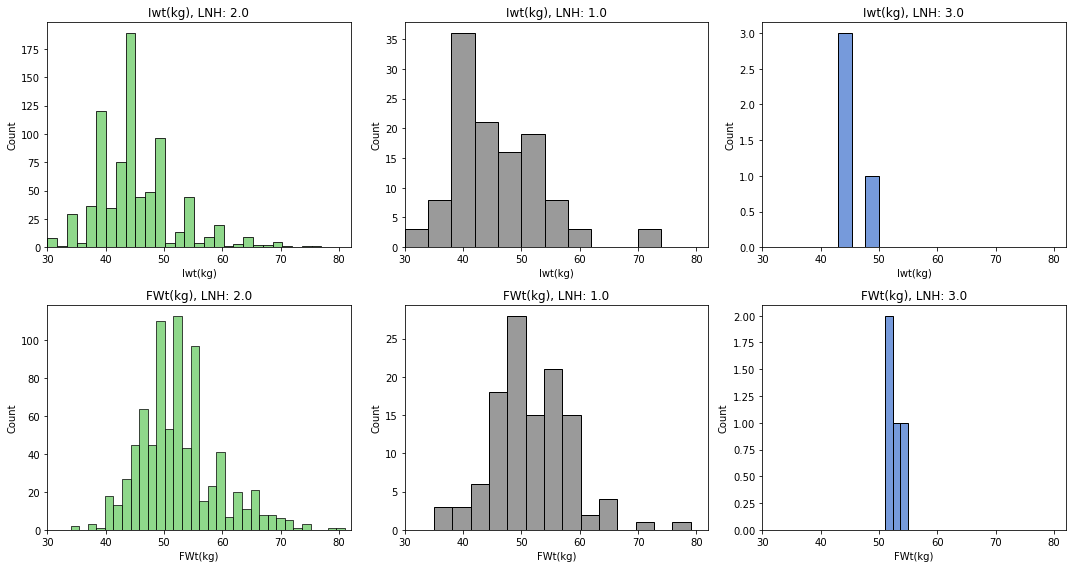

In [337]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

columns = ["Iwt(kg)", "FWt(kg)"]
for i, target in enumerate(dataset["LNH"].unique()):
    color = get_color()
    for j, col in enumerate(columns):
        selected = dataset[dataset["LNH"] == target]
        sns.histplot(selected, x=col, ax=axes[3*j + i], color=color)
        axes[3*j + i].set_xlim(30, 82)
        axes[3*j + i].set_title(f"{col}, LNH: {target}")

plt.tight_layout()
plt.show()

Vidimo kako trend podataka ima smisla, odnosno zdravorazumski je pretpostaviti da će od početka do kraja trudnoće težina majke porasti (što se može očitati iz pomaka srednje vrijednosti udesno na histogramskom prikazu).
  
Također možemo vidjeti za koliko se točno srednja vrijednost pomaknula u odnosu na početak i kraj trudnoće za svaku **LNH** vrijednost.

In [338]:
for target in dataset["LNH"].unique():
    means = []
    print(f"---Target: {target}---")
    for col in ["Iwt(kg)", "FWt(kg)"]:
        selected = dataset[dataset["LNH"] == target][col]
        means.append(selected.mean())
        print(f"{col} mean: {round(means[-1], 2)}")
    print(f"Difference: {means[1] - means[0]}\n")

---Target: 2.0---
Iwt(kg) mean: 45.56
FWt(kg) mean: 52.55
Difference: 6.991475765548287

---Target: 1.0---
Iwt(kg) mean: 45.23
FWt(kg) mean: 51.53
Difference: 6.2991452991452945

---Target: 3.0---
Iwt(kg) mean: 45.5
FWt(kg) mean: 52.75
Difference: 7.25



Čisto informativno, prikazat ćemo **Age(years)** i **Height(cm)** u obliku histograma u ovisnosti o svakoj pojedinoj **LNH** vrijednosti.


---Target: 2.0---
Age(years) mean: 22.89
Height(cm) mean: 140.72

---Target: 1.0---
Age(years) mean: 22.59
Height(cm) mean: 146.03

---Target: 3.0---
Age(years) mean: 26.75
Height(cm) mean: 147.75


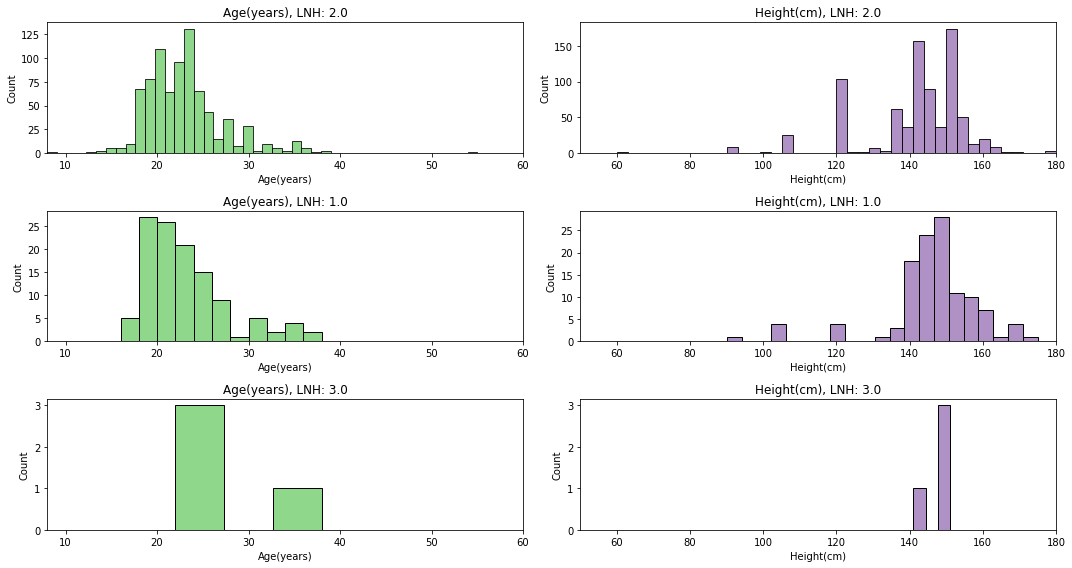

In [339]:
fig, axes = plt.subplots(3, 2, figsize=(15, 8))
axes = axes.flatten()

color = [get_color(), get_color()]
columns = ["Age(years)", "Height(cm)"]
for i, target in enumerate(dataset["LNH"].unique()):
    print(f"\n---Target: {target}---")
    for j, col in enumerate(columns):
        selected = dataset[dataset["LNH"] == target]
        sns.histplot(selected, x=col, ax=axes[2*i + j], color=color[j % 2])
        if (j == 0): axes[2*i + j].set_xlim(8, 60)
        else: axes[2*i + j].set_xlim(50, 180)
        axes[2*i + j].set_title(f"{col}, LNH: {target}")
        print(f"{col} mean: {round(selected[col].mean(), 2)}")
plt.tight_layout()
plt.show()

Vidimo da se srednja vrijednost godina i visine nije pretjerano mijenjala ovisno o težini djeteta što ukazuje da te značajke nisu međusobno previše korelirane.
  
Za kraj ćemo informativno prikazati odnos početne i konačne razine hemoglobina majke kao scatterplot, ovisno o različitim vrijednostima ciljne značajke (zbog jednostavnosti, kod za prikaz kopiran je iz bilježnice prvog dijela projekta).

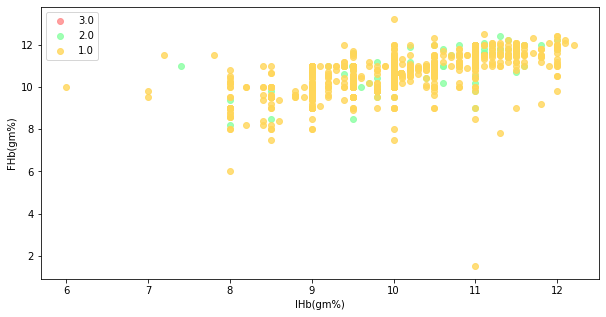

In [340]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

target = dataset['LNH'].value_counts()
colors = {0: '#ff8989', 1: '#89ffa2', 2: '#ffd659'}
for target_value, color in colors.items():
    subset = dataset[dataset['LNH'] == target_value]
    ax.scatter(subset['IHb(gm%)'], subset['FHb(gm%)'], c=color, label=f'{target.keys().values[target_value - 1]}', alpha=0.8)
ax.set_xlabel('IHb(gm%)')
ax.set_ylabel('FHb(gm%)')
ax.legend(loc='best')

#### 6. Transformacija tekstualnih značajki u numeričke

Sljedeći korak nakon ove eksplorativne analize podataka je sve kategoričke značajke u tekstualnom zapisu, a to su samo **Term/Preterm**, **Sex** i ciljna **LNH**, pretvoriti u numeričke kako bi mogli kasnije biti ulazi u modele strojnog učenja. Za to ćemo koristiti LabelEncoder od Scikit-learna.

In [341]:
for col in categorical_cols:
    le = LabelEncoder()
    dataset[col] = le.fit_transform(dataset[col])
dataset[categorical_cols]

,Term/Preterm,Sex,LNH
0,1,0,1
1,1,1,1
2,1,1,0
3,1,0,1
4,1,0,0
...,...,...,...
1785,1,1,1
1786,1,1,1
1787,1,1,1
1788,1,0,1


#### 7. Normalizacija
Kao posljednji korak u ovoj analizi podataka bit će izvršena normalizacija, sada svih, numeričkih podataka kako bi ih budući modeli mogli koristiti za svoje ulaze. Svi će se podaci preslikati u vrijednosti iz raspona **[0,1]**.

In [343]:
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(dataset)
dataset = pd.DataFrame(normalized_data, columns=dataset.columns)
dataset

,Age(years),Height(cm),Parity,ANC,Iwt(kg),FWt(kg),IBP_sys,IBP_dias,FBP_sys,FBP_dias,IHb(gm%),FHb(gm%),BS(RBS),Term/Preterm,Sex,BWt(kg),LNH
0,0.319149,0.716667,0.166667,1.000000,0.085106,0.170213,0.757143,0.633333,0.785714,0.389610,0.645161,1.000000,0.530612,1.0,0.0,0.550,0.5
1,0.361702,0.875000,0.166667,0.666667,0.808511,0.787234,0.614286,0.500000,0.714286,0.415584,0.709677,0.811966,0.571429,1.0,0.5,0.600,0.5
2,0.340426,0.791667,0.166667,0.666667,0.404255,0.446809,0.578571,0.200000,0.714286,0.389610,0.806452,0.863248,0.612245,1.0,0.5,0.475,0.0
3,0.234043,0.783333,0.166667,0.333333,0.404255,0.340426,0.571429,0.200000,0.642857,0.259740,0.645161,0.777778,0.619048,1.0,0.0,0.525,0.5
4,0.276596,0.750000,0.166667,1.000000,0.234043,0.297872,0.642857,0.333333,0.714286,0.389610,0.483871,0.743590,0.591837,1.0,0.0,0.450,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,0.212766,0.676470,0.000000,1.000000,0.106383,0.191489,0.642857,0.500000,0.785714,0.519481,0.645161,0.726496,0.612498,1.0,0.5,0.525,0.5
922,0.170213,0.676470,0.000000,1.000000,0.148936,0.234043,0.642857,0.500000,0.785714,0.519481,0.645161,0.726496,0.612498,1.0,0.5,0.500,0.5
923,0.361702,0.676470,0.166667,1.000000,0.212766,0.234043,0.714286,0.600000,0.828571,0.649351,0.564516,0.683761,0.612498,1.0,0.5,0.500,0.5
924,0.382979,0.676470,0.333333,1.000000,0.255319,0.255319,0.642857,0.500000,0.785714,0.597403,0.483871,0.641026,0.612498,1.0,0.0,0.550,0.5


#### 8. Značajka **BWt(kg)**
Za kraj, ova podsekcija će se baviti razmatranjem značajke **BWt(kg)**. Naime, za buduće zadatke klasifikacije ciljne varijable, ova je značajka nepotrebna (čak redundantna). Razlog tome je što zapravo prikazuje istu stvar kao naša ciljna značajka **LNH**, ali preciznije. Odnosno, govori nam točnu izmjerenu težinu novorođenog djeteta, dok je **LNH** samo ta ista vrijednost, ali kategorizirana u jednu od klasa po nekom rasponu. **BWt(kg)** nam je kroz ovu analizu cijelog dataseta bila korisna u nekim vizualizacijama, te stoga nije bila obrisana. Međutim, ako će budući zadaci biti klasifikacijske prirode (dakle na temelju **LNH**), pogrešno je ostaviti tu značajku da bude jedan od ulaza u model. No ako će zadatak biti regresija gdje će se predviđati točna numerička težina djeteta u kilogramima, tada bi se **BWt(kg)** mogla uzeti kao ciljna varijabla. Dakle, sve ovisi o nekim budućim zadaćama i modelima. Za sada, ostat će zakomentirano njeno uklanjanje.

In [344]:
# dataset.drop(["BWt(kg)"], axis=1, inplace=True)